In [1]:
import numpy as np

x=np.load("variables/x.npy")
y=np.load("variables/y.npy")
x_train=np.load("variables/x_train.npy")
x_test=np.load("variables/x_test.npy")
y_test=np.load("variables/y_test.npy")
y_train=np.load("variables/y_train.npy")

### REGRESSION LOGISTIQUE

In [2]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(x_train,y_train)
logistic_reg_pred = logistic_reg.predict(x_test)

### VALIDATION CROISÉE

In [3]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
logistic_reg_scores = cross_val_score(logistic_reg, x, 
                                      y, cv=10, scoring="f1")

display_scores(logistic_reg_scores)

Scores: [0.35643564 0.3125     0.34042553 0.375      0.32323232 0.31111111
 0.34951456 0.37113402 0.32258065 0.31914894]
Mean: 0.338108277487954
Standard deviation: 0.022648516813248205


#### Paramétrage du modèle (_fine tuning_)

Afin de trouver les meilleurs paramètres, nous allons utiliser la méthode d'optimisation GridSearchCV.


### GridSearchCV

In [4]:
%%capture --no-display
from sklearn.model_selection import GridSearchCV

logistic_reg_param_grid = [
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'penalty': ['none', 'l1', 'l2', 'elasticnet'], 
     'C': [100, 10, 1.0, 0.1, 0.01]}
  ]

grid_search = GridSearchCV(logistic_reg, logistic_reg_param_grid, cv=10,
                           scoring='f1', return_train_score=True)
grid_search.fit(x, y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': [100, 10, 1.0, 0.1, 0.01],
                          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             return_train_score=True, scoring='f1')

In [5]:
grid_search.best_params_

{'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}

In [6]:
best_logistic_reg = grid_search.best_estimator_

In [7]:
%%capture --no-display
best_logistic_reg_score = cross_val_score(best_logistic_reg, x, 
                                          y, cv=10, scoring="f1")

In [8]:
display_scores(best_logistic_reg_score)

Scores: [0.35643564 0.3125     0.34042553 0.37113402 0.32323232 0.32967033
 0.36538462 0.37113402 0.32258065 0.33684211]
Mean: 0.34293392354280805
Standard deviation: 0.02055426684823329


On peut voir que le modèle s'est un peu amélioré, comme l'on peut le voir avec la moyenne du f1_score

#### Matrice de Confusion

Nous allons maintenant utiliser afin d'étudier les performances de notre système de classification supervisé. Calculons maintenant cette matrice avec notre modèle amélioré.

In [9]:
%%capture --no-display
from sklearn.model_selection import cross_val_predict

y_true = (y == 1)

best_logistic_reg_pred = cross_val_predict(best_logistic_reg, x, y_true, cv=10)

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, best_logistic_reg_pred)

array([[3609,   90],
       [ 545,  166]], dtype=int64)

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_true, best_logistic_reg_pred)

0.6484375

In [12]:
recall_score(y_true, best_logistic_reg_pred)

0.23347398030942335

In [13]:
f1_score(y_true, best_logistic_reg_pred)

0.34332988624612204

#### Recall et precision en fonction du seuil

Affichons les valeurs du recall et de la précision en fonction du seuil ainsi que la valeur de la précision en fonction du recall

In [14]:
%%capture --no-display
y_scores = cross_val_predict(best_logistic_reg, x, y_true, cv=10,
                             method="decision_function")

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

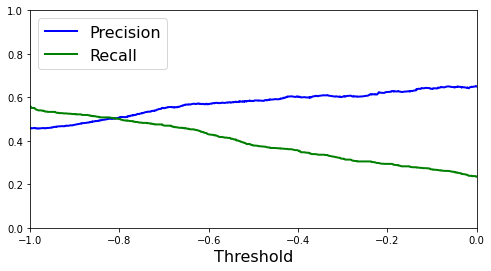

In [16]:
from matplotlib import pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-1, 0])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

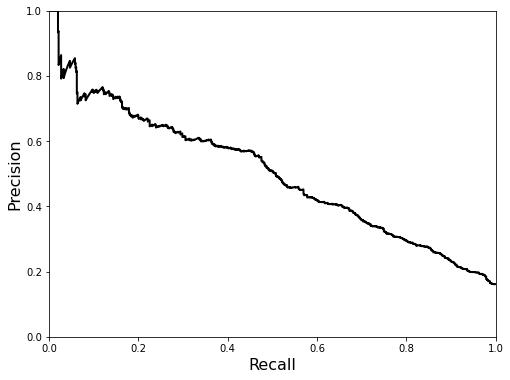

In [17]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "k-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

#### Courbe ROC

Affichons la courbe roc afin de confronter notre taux de vrai positif par rapport au taux de faux positif. plus la courbe se rapproche du coin supérieur gauche, plus notre taux de vrai positif est idéal, et on évite un maximum de faux positif. On utilise l'air sous la courbe ROC afin de comparer nos modèles, qui doit être le plus proche de 1.

In [18]:
from sklearn.metrics import roc_curve

fpr_rl, tpr_rl, thresholds = roc_curve(y_true, y_scores)

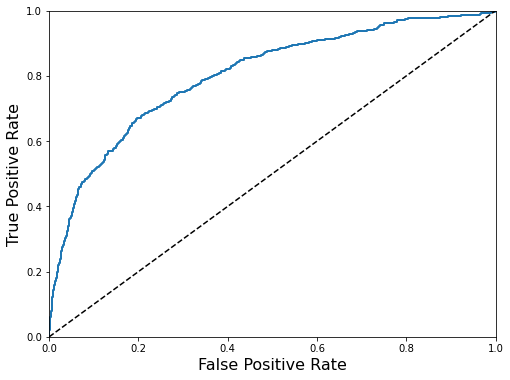

In [19]:
def plot_roc_curve(fpr_rl, tpr_rl, label=None):
    plt.plot(fpr_rl, tpr_rl, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rl, tpr_rl)
#save_fig("roc_curve_plot")
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_scores)

0.801937194414121

In [22]:
np.save('variables/fpr_rl.npy', fpr_rl)
np.save('variables/tpr_rl.npy', tpr_rl)